In [1]:
import pandas as pd
import seaborn as sns
import pandahouse as db
import matplotlib.pyplot as plt

In [2]:
sns.set(font_scale=2,
        style="darkgrid",
        rc={'figure.figsize': (44,20)})


In [3]:
def get_data(query):

    connection = {'host': 'https://clickhouse.lab.karpov.courses',
              'password': os.environ.get('PASSWORD_CLICK'),
              'user': 'student',
              'database': 'simulator'
             }

    df = db.read_clickhouse(query, connection=connection)
    return df

# Задание1
В наших данных использования ленты новостей есть два типа юзеров: те, кто пришел через платный трафик source = 'ads',
и те, кто пришел через органические каналы source = 'organic'.

Ваша задача — проанализировать и сравнить Retention этих двух групп пользователей. Решением этой задачи будет ответ на вопрос: отличается ли характер использования приложения у этих групп пользователей.

In [4]:
q = '''
WITH Table1 AS(
SELECT
    DISTINCT(user_id) as user,
    toDate(time) as date
FROM simulator_20220320.feed_actions
WHERE source = 'ads')

SELECT
    COUNT(Table2.user) as users,
    Table1.date as date
FROM
    (
    SELECT
        user_id as user
    FROM simulator_20220320.feed_actions
    GROUP BY user_id
    HAVING min(toDate(time)) = today() - 30
    ) AS Table2
JOIN Table1
Using user
GROUP BY date
'''

In [5]:
ads_table = get_data(q)
ads_table

,users,date
0,1199,2022-04-17
1,532,2022-04-18
2,446,2022-04-19
3,474,2022-04-20
4,425,2022-04-21
5,349,2022-04-22
6,382,2022-04-23
7,308,2022-04-24
8,303,2022-04-25
9,293,2022-04-26


In [6]:
q = '''
WITH Table1 AS(
SELECT
    DISTINCT(user_id) as user,
    toDate(time) as date
FROM simulator_20220320.feed_actions
WHERE source = 'organic')

SELECT
    COUNT(Table2.user) as users,
    Table1.date as date
FROM
    (
    SELECT
        user_id as user
    FROM simulator_20220320.feed_actions
    GROUP BY user_id
    HAVING min(toDate(time)) = today() - 30
    ) AS Table2
JOIN Table1
Using user
GROUP BY date
'''

In [7]:
organic_table = get_data(q)
organic_table


,users,date
0,1030,2022-04-17
1,526,2022-04-18
2,431,2022-04-19
3,450,2022-04-20
4,427,2022-04-21
5,410,2022-04-22
6,418,2022-04-23
7,399,2022-04-24
8,344,2022-04-25
9,354,2022-04-26


Посторим два графика и сравним ретеншн

<AxesSubplot:xlabel='date', ylabel='users'>

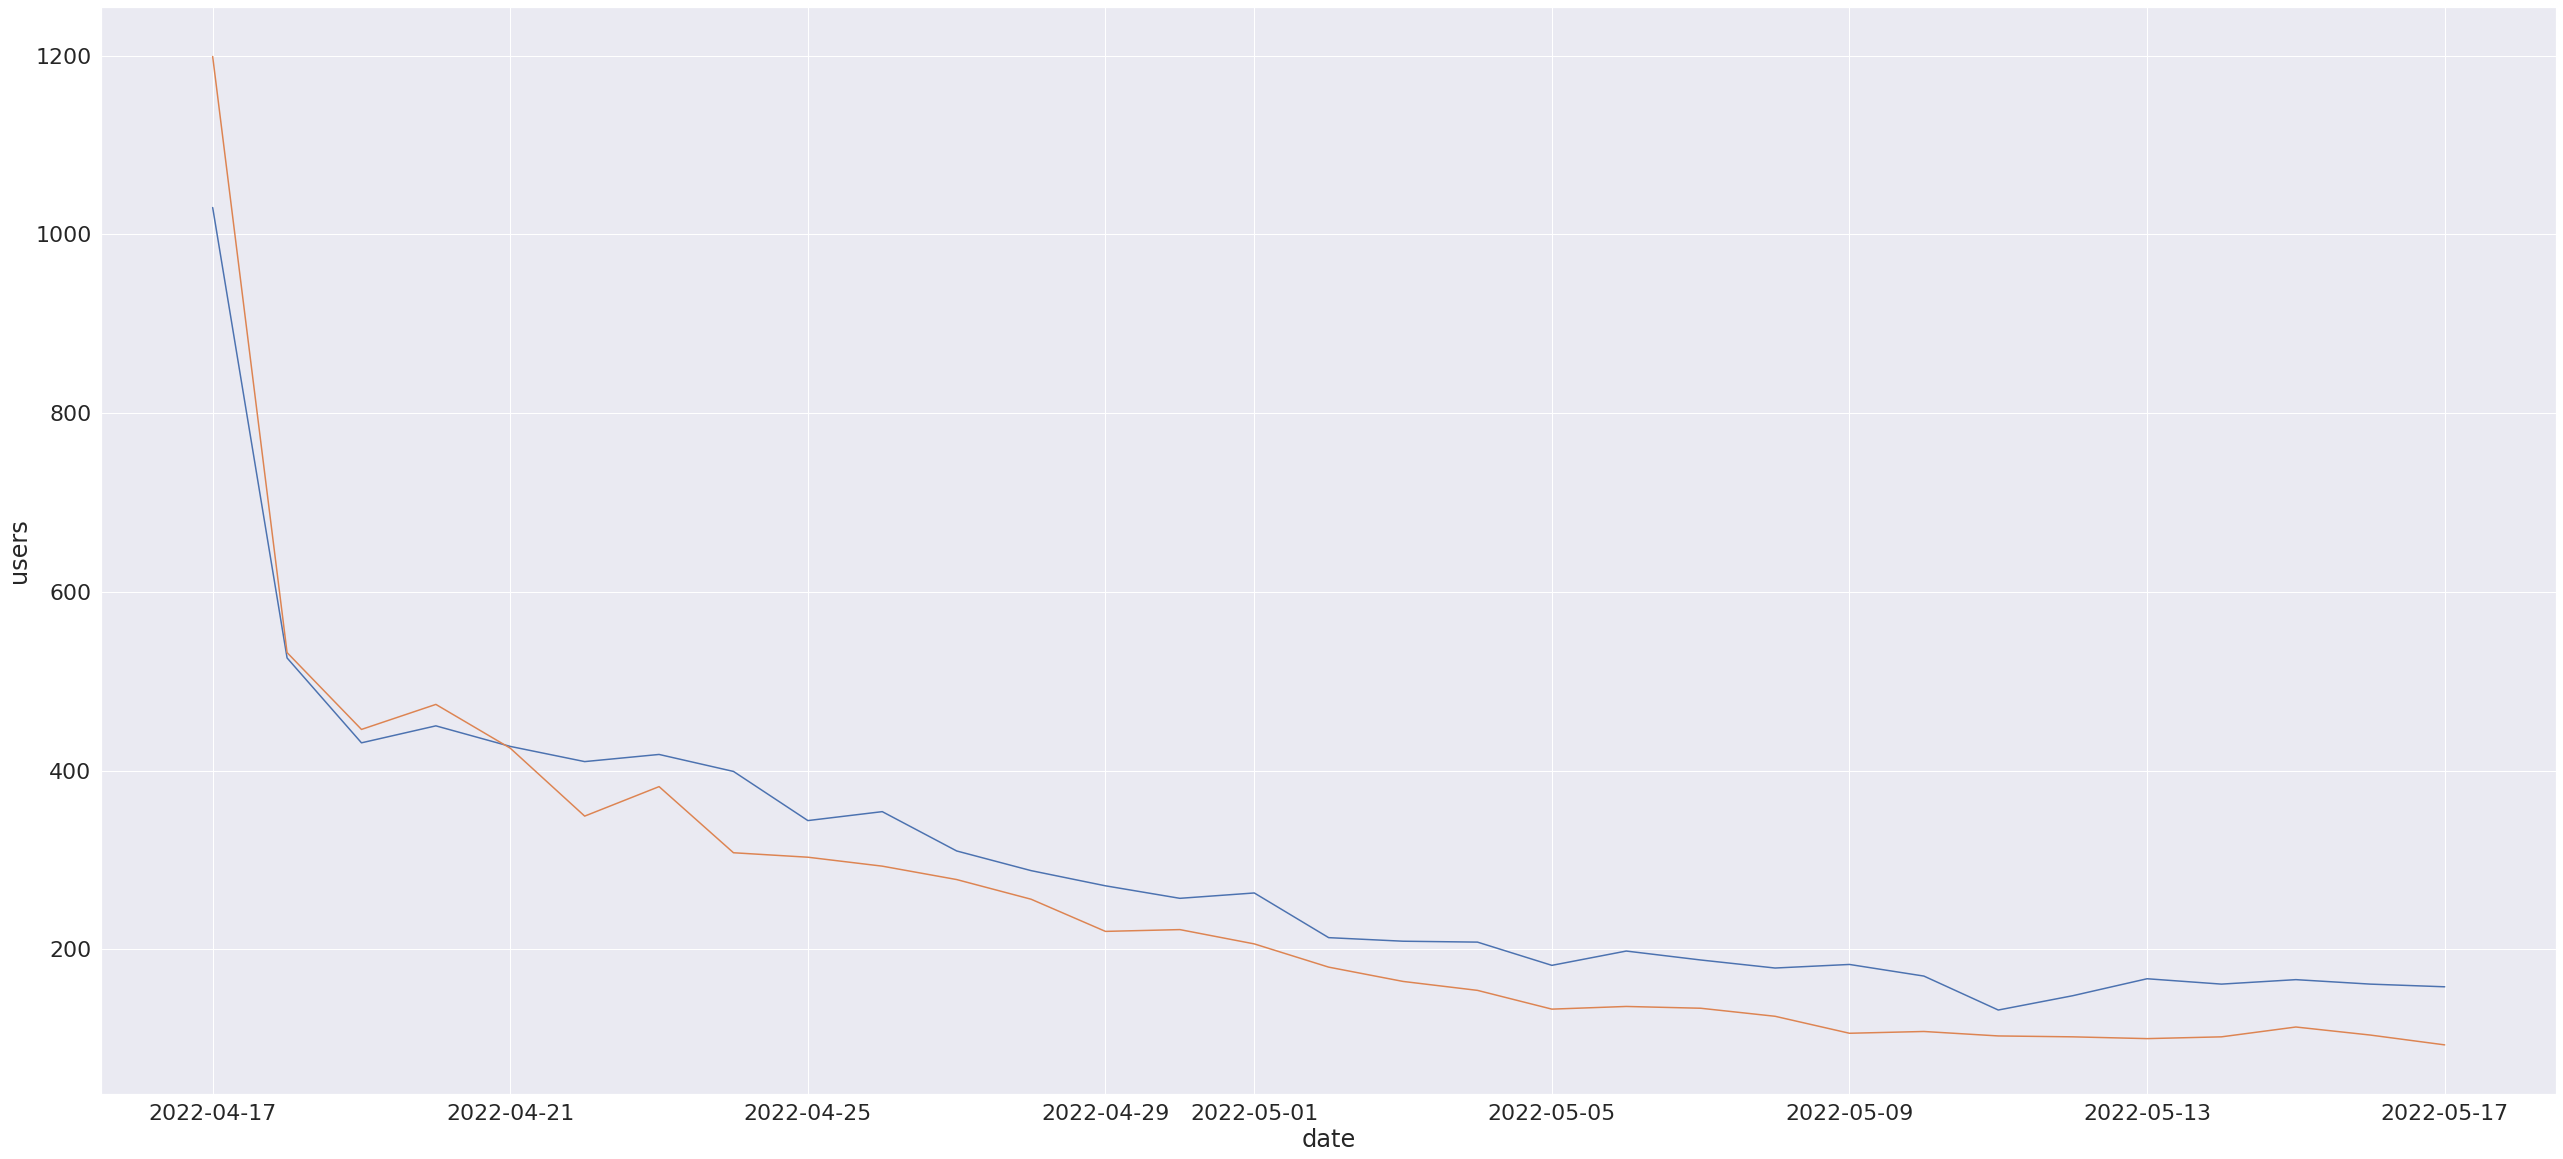

In [8]:
sns.lineplot(x = 'date', y = 'users', data = organic_table)
sns.lineplot(x = 'date', y='users', data = ads_table)

Из графика видно, что ретеншн групп очень значимо отличается, практически в два раза. Это говорит о том, что хоть и на коротком промежутке всплеск был выше у людей, которые пришли с рекламы, мы понимаем, что их сложнее удержать

# Задание2
Маркетологи запустили массивную рекламную кампанию, в результате в приложение пришло довольно много новых пользователей, вы можете видеть всплеск на графике активной аудитории.
Однако у нас есть сомнение в качестве трафика, изучите, что стало с рекламными пользователями в дальнейшем, как часто они продолжают пользоваться приложением?

In [9]:
# Пишем запрос, чтобы посмотреть на всплеск аудитории
q = '''
        SELECT
            COUNT(DISTINCT(user_id)) as users,
            source,
            toDate(time) AS date
        FROM simulator_20220320.feed_actions
        GROUP BY source, date
        HAVING toDate(time) < '2022-05-15'
            '''

In [10]:
df2 = get_data(q)
df2.sort_values('date', inplace=True)

In [11]:
df2.pivot_table(index = 'date', columns = 'source', values = 'users')

source,ads,organic
date,,
2022-02-16,670,528
2022-02-17,1161,1164
2022-02-18,1667,1721
2022-02-19,1928,2193
2022-02-20,2243,2674
...,...,...
2022-05-10,9633,8861
2022-05-11,10099,8885
2022-05-12,10109,8793


<AxesSubplot:xlabel='date', ylabel='users'>

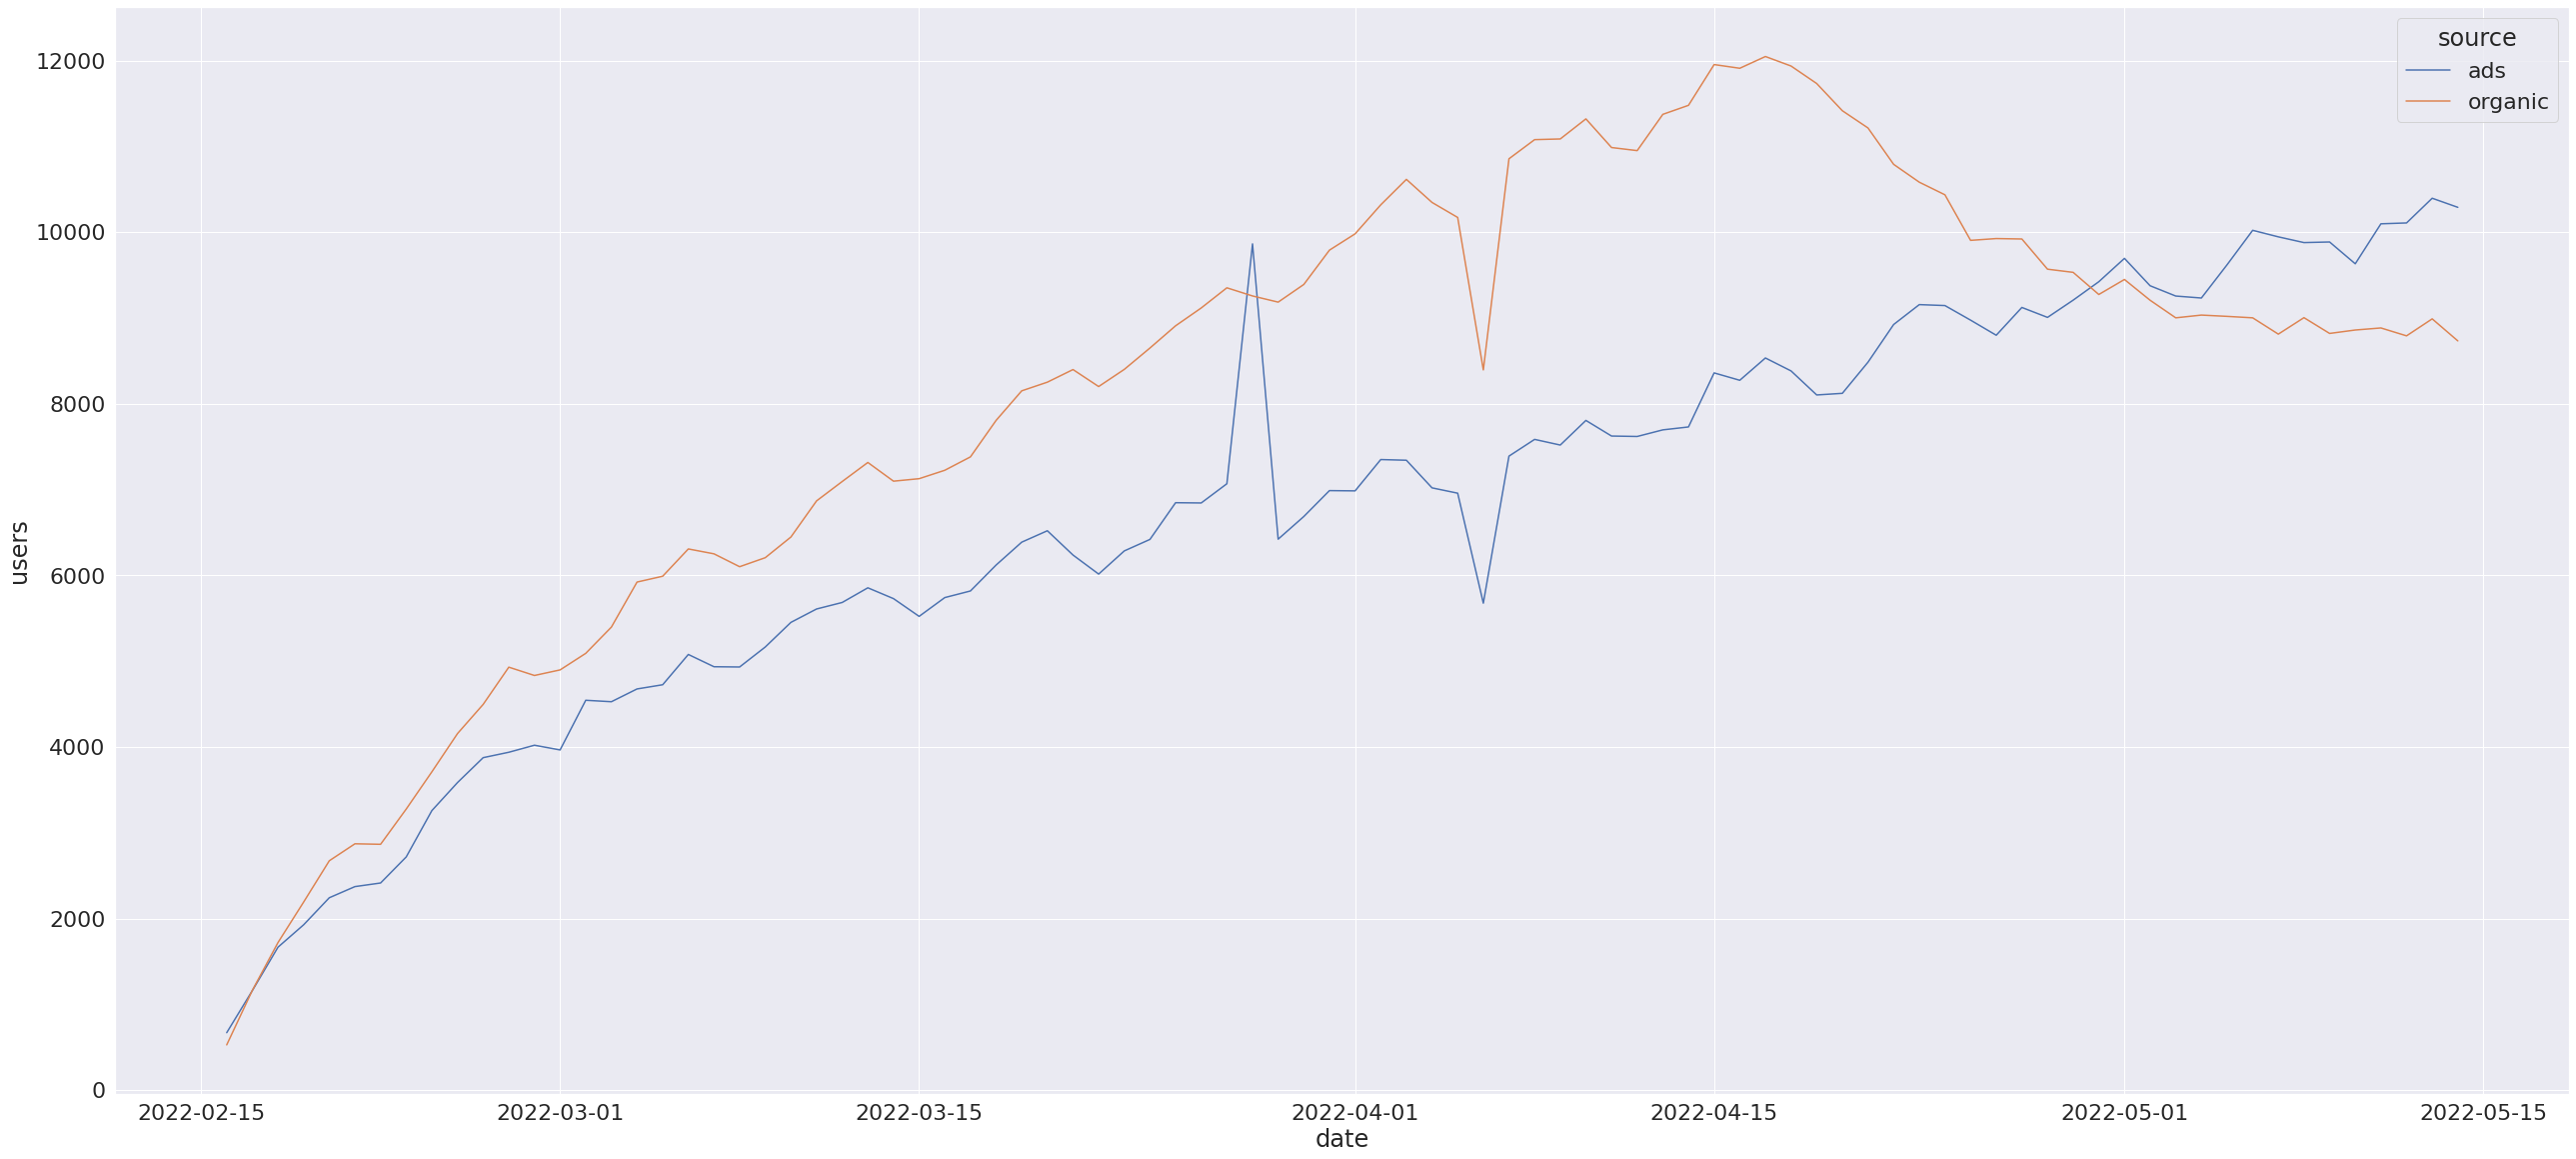

In [12]:
sns.lineplot(x = 'date', y = 'users', hue = 'source', data = df2)

Действительно, на графике заметный всплеск пользователей, которые были привлечены по платному трафику примерно после 2022-03-22. Исследуем данные подробнее, затем сделаем заключение, была ли качественная рекламная кампания. По графику видно, СПОЙЛЕР - нет, но , может быть, это не наша аудитория резко ушла. Проверим

In [13]:
df2[(df2['date'] > '2022-03-22') & (df2.source == 'ads')]

,users,source,date
140,6286,ads,2022-03-23
130,6420,ads,2022-03-24
124,6848,ads,2022-03-25
111,6845,ads,2022-03-26
103,7069,ads,2022-03-27
92,9865,ads,2022-03-28
66,6423,ads,2022-03-29
78,6687,ads,2022-03-30
50,6989,ads,2022-03-31
59,6986,ads,2022-04-01


Мы видим, что всплеск произошел 2022-03-28, посмотрим их ретеншн

In [14]:
q = '''WITH Table1 AS(
SELECT
    DISTINCT(user_id) as user,
    toDate(time) as date
FROM simulator_20220320.feed_actions
WHERE source = 'ads')

SELECT
    COUNT(Table2.user) as users,
    Table1.date as date
FROM
    (
    SELECT
        user_id as user
    FROM simulator_20220320.feed_actions
    GROUP BY user_id
    HAVING min(toDate(time)) = '2022-03-28'
    ) AS Table2
JOIN Table1
Using user
GROUP BY date'''

In [15]:
ads_anomaly = get_data(q)

In [16]:
ads_anomaly

,users,date
0,3688,2022-03-28
1,106,2022-03-29
2,124,2022-03-30
3,122,2022-03-31
4,108,2022-04-01
5,123,2022-04-02
6,93,2022-04-03
7,84,2022-04-04
8,88,2022-04-05
9,57,2022-04-06


In [17]:
ads_anomaly['users'].iloc[1] / (ads_anomaly['users'].iloc[0] - ads_anomaly['users'].iloc[1]) * 100


2.9592406476828588

Меньше трех процентов осталось на следующий день после крупной рекламы, не этого ждали маркетологи..

# Задание 3

Мы наблюдаем внезапное падение активной аудитории! Нужно разобраться, какие пользователи не смогли зайти в приложение, что их объединяет?

In [18]:
#Посмотрим на данные за период падения
q = '''
    SELECT
        DISTINCT(user_id),
        action,
        toDate(time) as time,
        gender,
        country,
        city,
        os,
        source
    FROM simulator_20220320.feed_actions
    WHERE  toDate(time) between '2022-04-05' and '2022-04-06'
    GROUP BY action, time, gender, country, city, os, source, user_id
    '''

In [19]:
problem_users = get_data(q)

In [20]:
#сравним количество уникальных пользователей(сколько зашли в приложение) по разным срезам, посмотрим, в каком из срезов тенденция нарушилась
problem_users.groupby(['time','os'])['user_id'].count()

time        os     
2022-04-05  Android    22196
            iOS        11835
2022-04-06  Android    18311
            iOS         9593
Name: user_id, dtype: int64

Тут произошли падения и на андроиде, и на ос - причина не в платформе

In [21]:
problem_users.groupby(['time','source'])['user_id'].count()

time        source 
2022-04-05  ads        13827
            organic    20204
2022-04-06  ads        11268
            organic    16636
Name: user_id, dtype: int64

И не в рекламном трафике дело, упали оба источника сохранив в целом свои пропорции

In [22]:
problem_users.groupby(['time','country'])['user_id'].count()

time        country    
2022-04-05  Azerbaijan       332
            Belarus          686
            Cyprus            32
            Estonia           46
            Finland          324
            Kazakhstan       598
            Latvia            38
            Russia         29940
            Switzerland       23
            Turkey           317
            Ukraine         1695
2022-04-06  Azerbaijan       331
            Belarus          649
            Cyprus            40
            Estonia           27
            Finland          308
            Kazakhstan       718
            Latvia            38
            Russia         23604
            Switzerland       32
            Turkey           358
            Ukraine         1799
Name: user_id, dtype: int64

А это уже интереснее. Мы видим, что значимое падение произошло у пользователей из России. Значит, произошла какая-то проблема с ними. Посмотрим по городам

In [23]:
city_trouble = problem_users.groupby(['time','city'])['user_id'].count().reset_index().sort_values(['user_id','city'], ascending=False).rename(columns = {'user_id':'users'})

In [24]:
city_trouble

,time,city,users
994,2022-04-05,Moscow,4614
1380,2022-04-05,Saint Petersburg,1521
1123,2022-04-05,Novosibirsk,422
1896,2022-04-05,Yekaterinburg,417
287,2022-04-05,Chelyabinsk,382
...,...,...,...
2703,2022-04-06,Kolosovka,1
580,2022-04-05,Karaman,1
317,2022-04-05,Chokh,1
2240,2022-04-06,Bol’shaya Kudara,1


Странно, 2022-04-05 в крупных городах показывало большой приток пользователей, тогда как на следующий день этих городов нет в топе. По крайне мере Москва и Питер должны были быть вверху таблицы на следующий день. Возьмем эти пять городов и посмотрим на них внимательнее

In [25]:
city_trouble[city_trouble['city'].isin(['Moscow','Saint Petersburg', 'Novosibirsk', 'Yekaterinburg','Chelyabinsk'])].head(10)

,time,city,users
994,2022-04-05,Moscow,4614
1380,2022-04-05,Saint Petersburg,1521
1123,2022-04-05,Novosibirsk,422
1896,2022-04-05,Yekaterinburg,417
287,2022-04-05,Chelyabinsk,382
2299,2022-04-06,Chelyabinsk,307


Так, мы видим, что у нас нет данных по городам. В крупных городах пользователи не пользовались нашим приложением 6 числа, кроме Челябинска. Т.е люди из 4 городов просто не смогли войти. Видимо случились проблемы с датацентром или провайдерами и данные перестали поступать.